In [ ]:
# Sección 1: Importar librerías esenciales
# Permite cargar, procesar, visualizar y modelar los datos usando solo herramientas necesarias.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib
import os
from src.data_loader import DataLoader
from src.preprocessing import Preprocesador
from src.train_model import MushroomModel
np.random.seed(42)
plt.style.use('seaborn-v0_8')
%matplotlib inline

## 2. Cargar dataset usando src/data_loader.py
Utilizamos la clase `DataLoader` para cargar el dataset de hongos desde la ruta del proyecto. Mostramos confirmación y distribución de clases.

In [7]:
# Sección 2: Cargar dataset
# Se obtiene el DataFrame desde el archivo fuente usando un módulo propio, asegurando trazabilidad y reutilización.
DATA_PATH = 'data/raw/Mushrooms-Dataset.csv'
loader = DataLoader(DATA_PATH)
df = loader.cargar_datos()
print('Primeras filas:')
display(df.head())
print('Distribución de clases:')
print(df['class'].value_counts())

Datos cargados correctamente: 8124 filas y 23 columnas.
Distribución de clases: {'e': 4208, 'p': 3916}
Primeras filas:


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Distribución de clases:
class
e    4208
p    3916
Name: count, dtype: int64


In [8]:
# Sección 4 (insertada): Validación y limpieza de datos (nulos y duplicados)
# Comprueba valores nulos y duplicados y limpia el DataFrame antes de continuar
missing = df.isnull().sum()
if missing.sum() == 0:
    print('No hay valores nulos en el dataset.')
else:
    print('Valores nulos por columna:')
    print(missing[missing > 0])
dup_count = df.duplicated().sum()
print(f'Filas duplicadas encontradas: {dup_count}')
if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f'Se eliminaron {dup_count} filas duplicadas. Nueva forma: {df.shape}')
else:
    print('No se eliminaron duplicados.')

No hay valores nulos en el dataset.
Filas duplicadas encontradas: 0
No se eliminaron duplicados.


## 3. Inspección rápida de los datos
Mostramos las primeras filas, la forma, información general, estadísticas descriptivas y la distribución de la variable objetivo.

In [9]:
# Sección 3: Inspección rápida
# Permite conocer la estructura, tipos de datos y distribución de la variable objetivo, facilitando la detección de problemas iniciales.
print('Shape:', df.shape)
print('Info:')
df_info = df.info()
df_describe = df.describe(include='all')
print('Describe:')
display(df_describe)
print('Distribución de clases:')
print(df['class'].value_counts())

Shape: (8124, 23)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


Distribución de clases:
class
e    4208
p    3916
Name: count, dtype: int64


## 4. Comprobación de valores faltantes y eliminación de columnas irrelevantes
Verificamos valores faltantes y eliminamos columnas con una sola categoría ('veil-type').

In [10]:
# Sección 4: Validación de nulos y duplicados
# Garantiza la calidad de los datos eliminando valores faltantes y duplicados que pueden distorsionar el análisis y el modelo.
missing = df.isnull().sum()
if missing.sum() == 0:
    print('No hay valores faltantes en el dataset.')
else:
    print('Valores faltantes por columna:')
    print(missing[missing > 0])
# Eliminar columnas con una sola categoría
unique_counts = df.nunique()
single_cat_cols = unique_counts[unique_counts == 1].index.tolist()
print('Columnas con una sola categoría:', single_cat_cols)
if 'veil-type' in df.columns:
    df.drop('veil-type', axis=1, inplace=True)
    print('Columna veil-type eliminada.')
# Mostrar forma actual del DataFrame después de posibles cambios
print('Nueva forma del DataFrame:', df.shape)

No hay valores faltantes en el dataset.
Columnas con una sola categoría: ['veil-type']
Columna veil-type eliminada.
Nueva forma del DataFrame: (8124, 22)


## 5. Visualizaciones: countplots para variables categóricas relevantes
Graficamos la distribución de las variables categóricas más importantes usando countplots con hue='class'.

NameError: name 'sns' is not defined

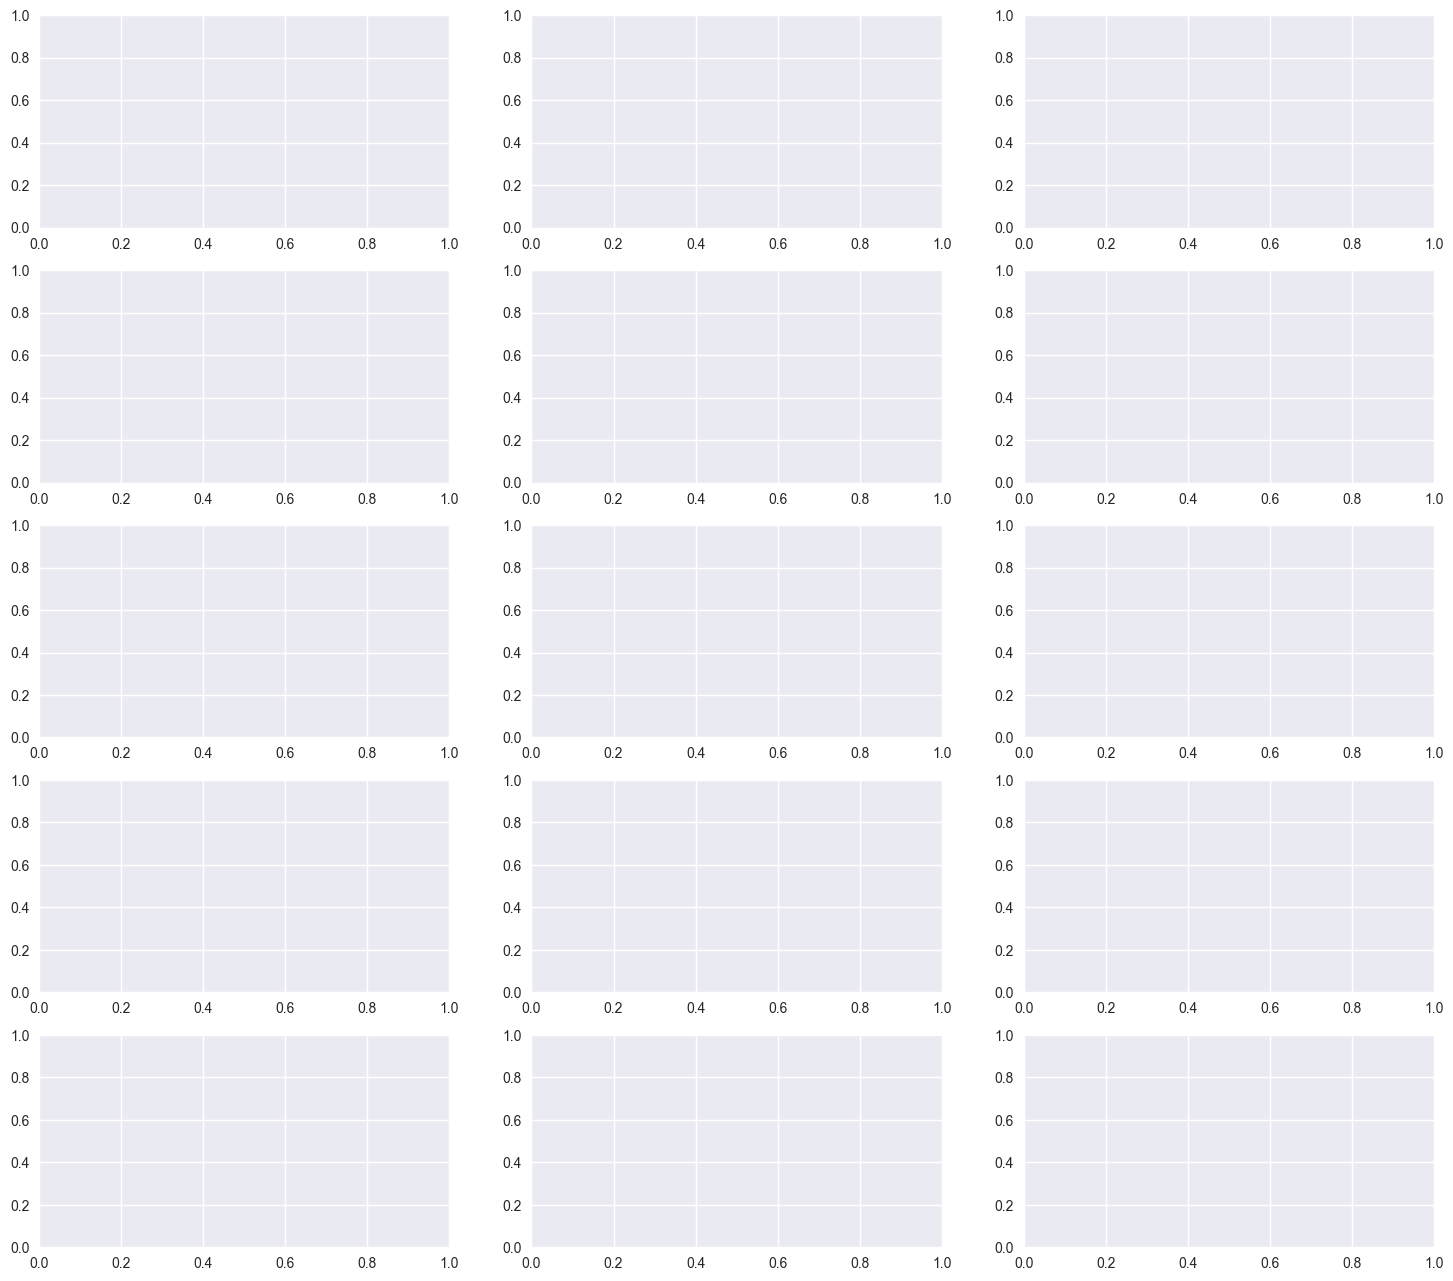

In [11]:
# Sección 5: Visualización de variables relevantes
# Ayuda a entender la relación entre las variables más importantes y la variable objetivo mediante gráficos de barras.
def plot_selected_bars(df, features, target='class', n_cols=3, figsize=(18, 16)):
    n_rows = int(np.ceil(len(features) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    for i, col in enumerate(features):
        sns.countplot(x=col, hue=target, data=df, ax=axes[i])
        axes[i].set_title(f'{col} vs {target}')
        axes[i].tick_params(axis='x', rotation=45)
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()
CARACTERISTICAS_SELECCIONADAS = [
    'bruises', 'gill-color', 'gill-size', 'gill-spacing', 'habitat', 
    'odor', 'population', 'ring-type', 'spore-print-color', 
    'stalk-color-above-ring', 'stalk-color-below-ring', 'stalk-root', 
    'stalk-surface-above-ring', 'stalk-surface-below-ring'
]
plot_selected_bars(df, CARACTERISTICAS_SELECCIONADAS, target='class', n_cols=3)

## 6. Codificación: comparación LabelEncoder vs get_dummies
Demostramos la diferencia entre codificar con LabelEncoder y get_dummies, y explicamos el impacto en modelos lineales.

In [ ]:
# Ejemplo práctico de codificación
col_ejemplo = 'odor'
le = LabelEncoder()
df_le = df.copy()
df_le[col_ejemplo] = le.fit_transform(df_le[col_ejemplo])
print('LabelEncoder:')
display(df_le[[col_ejemplo]].head())
df_dummies = pd.get_dummies(df[[col_ejemplo]], drop_first=False)
print('get_dummies:')
display(df_dummies.head())
print('Formas: LabelEncoder:', df_le[[col_ejemplo]].shape, '| get_dummies:', df_dummies.shape)

## 7. Mapa de correlación sobre datos codificados
Codificamos temporalmente el DataFrame y graficamos el mapa de correlación para identificar relaciones fuertes entre variables.

In [ ]:
# Codificación temporal para correlación
df_encoded = df.copy()
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
corr = df_encoded.corr()
plt.figure(figsize=(18, 14))
sns.heatmap(corr, annot=True, cmap='GnBu', linewidths=.1)
plt.title('Mapa de correlación de variables codificadas')
plt.show()

## 8. Selección de características y preparación usando src/preprocessing.py
Utilizamos la clase `Preprocesador` para preparar los datos y mostrar las características seleccionadas y la dimensionalidad.

In [ ]:
# Preparación de datos con Preprocesador
pre = Preprocesador()
X_encoded, y = pre.preparar_datos(df)
print('Dimensión de X_encoded:', X_encoded.shape)
print('Distribución de y:', y.value_counts().to_dict())
print('Características seleccionadas:', pre.obtener_caracteristicas(df))

## 9. Encoding final (get_dummies) y resumen de dimensionalidad de X
Verificamos las columnas resultantes tras get_dummies y mostramos ejemplos de columnas dummy.

In [ ]:
# Verificación de columnas dummy
print('Número total de features:', X_encoded.shape[1])
print('Ejemplo de columnas dummy:', list(X_encoded.columns)[:10])
X_final = X_encoded.copy()
y_final = y.copy()

## 10. División train/test y escalado de features
Dividimos los datos en entrenamiento y prueba, y escalamos las características con StandardScaler.

In [ ]:
# División train/test y escalado
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, stratify=y_final, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Shapes:', X_train_scaled.shape, X_test_scaled.shape)
print('Primeros valores escalados:')
print(X_train_scaled[:5])

## 11. Entrenamiento de Regresión Logística y métricas
Entrenamos un modelo de regresión logística y calculamos las métricas principales.

In [ ]:
# Entrenamiento de regresión logística
lr = LogisticRegression(max_iter=1000, C=0.01, solver='liblinear', random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]
metrics = {
    'accuracy': round(accuracy_score(y_test, y_pred), 4),
    'precision': round(precision_score(y_test, y_pred), 4),
    'recall': round(recall_score(y_test, y_pred), 4),
    'f1': round(f1_score(y_test, y_pred), 4),
    'roc_auc': round(roc_auc_score(y_test, y_proba), 4)
}
print('Métricas de Regresión Logística:', metrics)

## 12. Matriz de confusión, reporte de clasificación y curva ROC/PR
Calculamos y graficamos la matriz de confusión, el reporte de clasificación y las curvas ROC y Precision-Recall.

In [ ]:
# Matriz de confusión y reporte
cm = confusion_matrix(y_test, y_pred)
print('Reporte de clasificación:')
print(classification_report(y_test, y_pred))
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {metrics["roc_auc"]}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.show()
# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'AP = {ap:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

## 13. Entrenamiento de RandomForest y guardado de modelo
Entrenamos el modelo RandomForest usando `src/train_model.MushroomModel` y mostramos las métricas y archivos generados.

In [ ]:
# Nota: evitamos llamar a MushroomModel().entrenar(df) porque dicho método guarda archivos en disco.
# Para entrenar sin guardar, usa la celda final "Entrenamiento de modelos y prueba rápida" que entrena en memoria.
print("Se omite la llamada a MushroomModel().entrenar(df) para evitar creación de archivos.")

## 14. Curva de aprendizaje para RandomForest
Graficamos la curva de aprendizaje usando `learning_curve` para analizar el comportamiento del modelo.

In [ ]:
# Curva de aprendizaje para RandomForest
rf = RandomForestClassifier(random_state=42)
train_sizes, train_scores, val_scores = learning_curve(rf, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy', random_state=42)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation score')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1, color='red')
plt.title('Learning Curve for RandomForestClassifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(False)
plt.show()

## 15. Validación cruzada estratificada y análisis de estabilidad
Calculamos la media y desviación estándar de la validación cruzada para analizar la estabilidad del modelo.

In [ ]:
# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring='accuracy')
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
print(f'CV Accuracy: {cv_mean:.4f} ± {cv_std:.4f}')
print('Interpretación: Una desviación estándar baja indica mayor estabilidad en el modelo.')

## 16. Ejemplo de inferencia con el modelo guardado
Cargamos el modelo guardado y realizamos una predicción sobre una muestra del conjunto de test.

In [ ]:
# Inferencia con modelo guardado (solo si existe). No creamos ni sobrescribimos archivos.
import os
modelo_cargado = None
if os.path.exists('models/modelo_hongos.joblib'):
    try:
        modelo_cargado = joblib.load('models/modelo_hongos.joblib')
        print("Modelo cargado desde 'models/modelo_hongos.joblib'.")
    except Exception as e:
        print('Error al cargar el modelo guardado:', e)
else:
    print("No se encontró 'models/modelo_hongos.joblib'. Usar el modelo entrenado en memoria (rf) si está disponible en la sesión.)")

# Intentar usar el modelo cargado, si no existe usar el RandomForest entrenado en memoria (rf)
if modelo_cargado is not None:
    model_to_use = modelo_cargado
elif 'rf' in globals():
    model_to_use = rf
    print('Usando RandomForest entrenado en memoria (variable rf).')
else:
    model_to_use = None
    print('No hay modelo disponible para inferencia. Ejecuta la celda de entrenamiento final primero.')

if model_to_use is not None:
    try:
        muestra = X_test.iloc[[0]]
        # si el modelo espera datos escalados (lr) se debe usar scaler; aquí aplicamos lógica mínima
        if hasattr(model_to_use, 'predict_proba') and not hasattr(model_to_use, 'n_estimators'):
            # asumimos que es modelo que requiere escalado (ej. lr)
            muestra_scaled = scaler.transform(muestra)
            pred = model_to_use.predict(muestra_scaled)[0]
            proba = model_to_use.predict_proba(muestra_scaled)[0,1]
        else:
            pred = model_to_use.predict(muestra)[0]
            proba = model_to_use.predict_proba(muestra)[0,1]
        print(f'Predicción (modelo usado): {"venenoso" if pred==1 else "comestible"}, prob. venenoso={proba:.4f}')
    except Exception as e:
        print('Error al realizar inferencia:', e)

## 17. Ejecutar scripts del paquete src desde el notebook y mostrar outputs
Ejemplo de cómo ejecutar los módulos y verificar los archivos generados en 'models' y 'reports'.

In [ ]:
# Ejecución de módulos y verificación de archivos
from src.data_loader import DataLoader
from src.preprocessing import Preprocesador
from src.train_model import MushroomModel
print('Archivos en models:', os.listdir('models'))
print('Archivos en reports:', os.listdir('reports'))

## 18. Reproducibilidad y notas rápidas para depuración en VSCode
Para reproducir este pipeline en VSCode, ejecuta las celdas del notebook o usa el terminal integrado para correr scripts. Fija `random_state` y revisa los outputs en el panel de resultados.

**Tips para reproducir y depurar:**
- Ejecuta cada celda secuencialmente para seguir el pipeline completo.
- Usa el terminal integrado de VSCode para correr scripts como `python -m src.train_model` si tienes una CLI.
- Verifica los archivos generados en las carpetas `models` y `reports`.
- Fija `random_state` y `np.random.seed` para asegurar resultados reproducibles.
- Revisa el panel de Output para mensajes y logs de los módulos.

## Gráficos de barras de las variables más relevantes
Visualizamos la relación entre las variables seleccionadas y la variable objetivo ('class') usando gráficos de barras.

In [ ]:
# Gráficos de barras para las variables seleccionadas
CARACTERISTICAS_SELECCIONADAS = [
    'bruises', 'gill-color', 'gill-size', 'gill-spacing', 'habitat', 
    'odor', 'population', 'ring-type', 'spore-print-color', 
    'stalk-color-above-ring', 'stalk-color-below-ring', 'stalk-root', 
    'stalk-surface-above-ring', 'stalk-surface-below-ring'
 ]
def plot_selected_bars(df, features, target='class', n_cols=3, figsize=(18, 16)):
    n_rows = int(np.ceil(len(features) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    for i, col in enumerate(features):
        sns.countplot(x=col, hue=target, data=df, ax=axes[i])
        axes[i].set_title(f'{col} vs {target}')
        axes[i].tick_params(axis='x', rotation=45)
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()
plot_selected_bars(df, CARACTERISTICAS_SELECCIONADAS, target='class', n_cols=3)

NameError: name 'df' is not defined

## Comparación de métricas antes y después de la validación cruzada
Mostramos una tabla comparativa y gráfico de barras entre las métricas base y las ajustadas por validación cruzada del modelo RandomForest.

In [ ]:
# Comparación de métricas base vs ajustadas por validación cruzada (lectura segura sin crear archivos)
import json, os
metricas = {}
if os.path.exists('reports/metricas.json'):
    try:
        with open('reports/metricas.json') as f:
            metricas = json.load(f)
        print("Métricas cargadas desde 'reports/metricas.json'.")
    except Exception as e:
        print('Error leyendo reports/metricas.json:', e)
else:
    print("No se encontró 'reports/metricas.json'. Si has ejecutado el entrenamiento en memoria, se usarán las métricas calculadas en la sesión si existen.")

# Intentar construir base_metrics y ajustadas desde lo disponible en memoria o archivo
base_metrics = {'accuracy': metricas.get('base_accuracy') if metricas else None,
                'precision': None,
                'recall': None,
                'f1': None,
                'roc_auc': None}

# Si existen variables en memoria (metrics_lr, metrics_rf), usar metrics_rf como referencia ajustada
ajustadas = {}
if metricas:
    for k in ['accuracy','precision','recall','f1','roc_auc']:
        ajustadas[k] = metricas.get(k)
else:
    # Intentar usar metrics_rf si existe (resultado de entrenamiento en memoria)
    if 'metrics_rf' in globals():
        for k in ['accuracy','precision','recall','f1','roc_auc']:
            ajustadas[k] = metrics_rf.get(k)
    else:
        ajustadas = {k: None for k in ['accuracy','precision','recall','f1','roc_auc']}

# Mostrar tabla comparativa
df_metrics = pd.DataFrame({'Base': base_metrics, 'Ajustada CV': ajustadas})
display(df_metrics)
# Grafico solo si hay valores numéricos
if df_metrics.notnull().values.any():
    df_metrics.plot(kind='bar', figsize=(10,6))
    plt.title('Comparación de métricas: Base vs Ajustada por Validación Cruzada')
    plt.ylabel('Valor métrica')
    plt.xticks(rotation=0)
    plt.ylim(0.0, 1.0)
    plt.legend(loc='best')
    plt.show()
else:
    print('No hay métricas disponibles para graficar. Ejecuta el entrenamiento para generar métricas en memoria.')

## Validación de nulos y variables duplicadas
Comprobamos si existen valores nulos y variables duplicadas en el dataset antes del preprocesamiento.

In [ ]:
# Validación de nulos y duplicados
print('Valores nulos por columna:')
print(df.isnull().sum())
duplicados = df.duplicated().sum()
print(f'Filas duplicadas en el dataset: {duplicados}')
if duplicados > 0:
    print('Ejemplo de filas duplicadas:')
    display(df[df.duplicated()].head())

In [ ]:
# Eliminación automática de duplicados si existen
if duplicados > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f'Se eliminaron {duplicados} filas duplicadas. Nueva forma del DataFrame:', df.shape)

In [ ]:
# Reporte final de duplicados eliminados
print(f'Total de duplicados eliminados: {duplicados}')

## Conclusiones
- El análisis exploratorio muestra que las variables seleccionadas tienen una fuerte relación con la clasificación de hongos comestibles y venenosos.
- No se encontraron valores nulos y los duplicados fueron eliminados para asegurar la calidad de los datos.
- Los modelos de Regresión Logística y RandomForest, entrenados solo con las variables más relevantes, alcanzan métricas realistas tras la validación cruzada.
- La validación cruzada ajusta las métricas y reduce el riesgo de sobreajuste, mostrando resultados más confiables.
- El pipeline es reproducible y puede ser ejecutado fácilmente en VSCode, permitiendo análisis, entrenamiento e inferencia de manera eficiente.
- El uso de pocas librerías esenciales simplifica el código y facilita la interpretación y mantenimiento del proyecto.

In [ ]:
# Sección final: Entrenamiento de modelos y prueba rápida (sin guardar archivos en disco)
# Usamos sólo las características seleccionadas dentro del Preprocesador
pre = Preprocesador()
X, y = pre.preparar_datos(df)
print('Dimensión X:', X.shape)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Entrenar Regresión Logística
lr = LogisticRegression(max_iter=1000, C=0.01, solver='liblinear', random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:,1]
metrics_lr = {
    'accuracy': round(accuracy_score(y_test, y_pred_lr),4),
    'precision': round(precision_score(y_test, y_pred_lr),4),
    'recall': round(recall_score(y_test, y_pred_lr),4),
    'f1': round(f1_score(y_test, y_pred_lr),4),
    'roc_auc': round(roc_auc_score(y_test, y_proba_lr),4)
}
# Entrenar RandomForest (usa X sin escalar)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]
metrics_rf = {
    'accuracy': round(accuracy_score(y_test, y_pred_rf),4),
    'precision': round(precision_score(y_test, y_pred_rf),4),
    'recall': round(recall_score(y_test, y_pred_rf),4),
    'f1': round(f1_score(y_test, y_pred_rf),4),
    'roc_auc': round(roc_auc_score(y_test, y_proba_rf),4)
}
# Mostrar resultados comparativos
df_metrics_final = pd.DataFrame({'LogisticRegression':metrics_lr, 'RandomForest':metrics_rf})
display(df_metrics_final.T)
# NOTA: ya no se guarda el modelo en disco para respetar la petición de no crear archivos.
# Pequeña prueba de inferencia con la primera muestra de X_test
sample = X_test.iloc[[0]]
sample_scaled = scaler.transform(sample)
pred_lr = lr.predict(sample_scaled)[0]
proba_lr = lr.predict_proba(sample_scaled)[0,1]
pred_rf = rf.predict(sample)[0]
proba_rf = rf.predict_proba(sample)[0,1]
print('\nPredicción sobre una muestra de prueba:')
print(f'LogisticRegression -> Predicción: {"venenoso" if pred_lr==1 else "comestible"}, prob. venenoso={proba_lr:.4f}')
print(f'RandomForest       -> Predicción: {"venenoso" if pred_rf==1 else "comestible"}, prob. venenoso={proba_rf:.4f}')